In [36]:
import datetime
import multiprocessing as mp
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm

In [37]:
from kaggle_secrets import UserSecretsClient

BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_DIFFUSION_STEPS = 1000
EPOCHS = 40
LOG_FREQUENCY = 200
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


## Noise Scheduler

In [38]:
class DDPMScheduler:
    def __init__(self, beta_start, beta_end, num_train_timesteps):
        # for the forward process q(x_t|x_0)
        self.timesteps = torch.arange(num_train_timesteps)
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.num_train_steps = num_train_timesteps
        self.beta = torch.linspace(self.beta_start, self.beta_end, self.num_train_steps)
        self.alphas = 1. - self.beta
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        # for the reverse process q(x_{t-1}|x_t,x_0)
        self.sigmas = (1 - self.alphas[1:]) * (1 - self.alphas_cumprod[:-1]) / (1 - self.alphas_cumprod[1:])
        self.sigmas = self.sigmas.sqrt()
        
        
    def add_noise(self, x0, noise, t):
        alphas_cumprod_t = self.alphas_cumprod.to(x0.device)[t].reshape(-1, 1, 1, 1)
        return alphas_cumprod_t.sqrt() * x0 + (1 - alphas_cumprod_t).sqrt() * noise

## Data

In [39]:
# Define the transforms to be applied to the data
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(), 
        transforms.Normalize((0,), (1,))
    ]
)

# Load the training dataset
train_set = torchvision.datasets.MNIST(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=mp.cpu_count(), drop_last=True)

x, y = next(iter(train_dl))
x.shape, y.shape, x.mean(), x.std(), x.max(), x.min()

(torch.Size([128, 1, 32, 32]),
 torch.Size([128]),
 tensor(0.1355),
 tensor(0.2948),
 tensor(1.),
 tensor(0.))

## Model

In [40]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out
    
class ResNetWithTimeEmbed(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.resnet1 = ResNetBlock(in_channels, out_channels)
        self.resnet2 = ResNetBlock(out_channels, out_channels, stride)
        self.time_embedding = nn.Linear(1, out_channels)
        
    def forward(self, x: torch.FloatTensor, t: torch.LongTensor) -> torch.FloatTensor:
        x = self.resnet2(self.resnet1(x))
        
        time_embed = self.time_embedding(t)
        emb = time_embed[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        
        return x + emb
    
class Down(nn.Module):
    def __init__(self, layers: List[int]):
        super().__init__()
        self.conv_layers = nn.ModuleList([ResNetWithTimeEmbed(dim_in, dim_out) for dim_in, dim_out in zip(layers[:-1], layers[1:])])
        self.bns = nn.ModuleList([nn.BatchNorm2d(feature_len) for feature_len in layers[1:-1]])
        self.down = nn.MaxPool2d(2)
        
    def forward(self, x, t):
        for layer, batch_norm in zip(self.conv_layers[:-1], self.bns):
            x = self.down(batch_norm(F.gelu(layer(x, t))))
        return self.down(self.conv_layers[-1](x, t))
    
class Up(nn.Module):
    def __init__(self, layers: List[int]):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv_layers = nn.ModuleList([ResNetWithTimeEmbed(dim_in, dim_out) for dim_in, dim_out in zip(layers[:-1], layers[1:])])
        self.bns = nn.ModuleList([nn.BatchNorm2d(feature_len) for feature_len in layers[1:-1]])
        
    def forward(self, x, t):
        for layer, batch_norm in zip(self.conv_layers[:-1], self.bns):
            x = F.gelu(batch_norm(layer(self.up(x), t)))
        return self.conv_layers[-1](self.up(x), t)
    
    
class UNet(nn.Module):
    def __init__(self, layers: List[int]):
        super().__init__()
        self.up = Up(layers[::-1])
        self.down = Down(layers)
        
        self.down_outputs = []
        
        self.up.up.register_forward_hook(lambda module, input, output: output + self.down_outputs.pop(-1))
            
        for module in self.down.conv_layers.children():
            module.register_forward_hook(lambda module, input, output: self.down_outputs.append(output))
        
    def forward(self, x, t):
        return self.up(self.down(x, t), t)

## Utils

In [41]:
def get_noised_inputs(noise_scheduler, images: torch.FloatTensor, batch_size: int, num_train_steps) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    noise = torch.randn(images.shape).to(images.device)
    # Sample a random timestep for each image
    timesteps = torch.randint(
        0,
        num_train_steps,
        (batch_size,),
        device=images.device,
    ).long()

    # Add noise to the images according to the noise magnitude at each timestep
    # (this is the forward diffusion process)
    return noise_scheduler.add_noise(images, noise, timesteps), noise

In [42]:
def generate_denoised_images_ddpm(
    model: nn.Module,
    diffusion_steps: int,
    x_t: torch.FloatTensor,
    noise_scheduler
) -> List[torch.FloatTensor]:        
    x_ts = [x_t.cpu()]
    with torch.inference_mode():
        for t in range(diffusion_steps - 1, 0, -1):
            time = torch.FloatTensor([t] * len(x_t))[:, None] / diffusion_steps
            noise_pred = model(x_t.to(DEVICE), time.to(DEVICE))
            alpha_bar_t = noise_scheduler.alphas_cumprod[t]
            alpha_t = noise_scheduler.alphas[t]
            sigma_t = noise_scheduler.sigmas[t - 1]
            
            mu_t = (x_t.to(DEVICE) - ((1 - alpha_t) / (1 - alpha_bar_t).sqrt()) * noise_pred) / alpha_t.sqrt()
            x_t = mu_t + torch.randn_like(mu_t) * sigma_t
            if t == 1 or t % 100 == 0:
                x_ts.append(x_t.cpu())
            
    return x_ts

## Train

In [43]:
import matplotlib.pyplot as plt

def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(len(images), 1))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

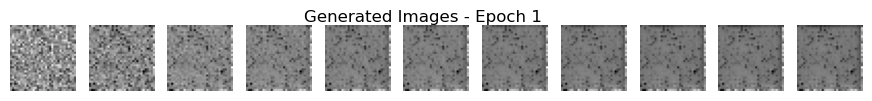

In [ ]:
layers = [1, 16, 32, 128]
model = UNet(layers).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

noise_scheduler = DDPMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
#     beta_schedule="scaled_linear",
    num_train_timesteps=NUM_DIFFUSION_STEPS,
)

for epoch in tqdm(range(EPOCHS)):
    for i, (x, _) in enumerate(train_dl):
        x = x.to(DEVICE)
        noise = torch.randn(x.shape).to(DEVICE)
        timesteps = torch.randint(0, NUM_DIFFUSION_STEPS, (len(x),)).long().to(DEVICE)
        noised_images = noise_scheduler.add_noise(x, noise, timesteps)
        noise_pred = model(noised_images, timesteps[:, None] / NUM_DIFFUSION_STEPS)
        
        loss = F.mse_loss(noise_pred, noise, reduction="none").mean()        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        optimizer.zero_grad()
    
    
    images = generate_denoised_images_ddpm(model.eval(), NUM_DIFFUSION_STEPS, torch.randn(x.shape), noise_scheduler)
    show_images([img[0] for img in images], f'Generated Images - Epoch {epoch+1}')

In [ ]:
torch.save(model, "ddpm.mod")